In [5]:
#@title CLIP preprocess and Imports
!pip -q install ftfy regex tqdm
!pip -q install git+https://github.com/openai/CLIP.git
import os
import numpy as np
import h5py
import torch
import clip
import cv2
from PIL import Image
from IPython.display import Image as ImagePy, display
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import random

device = "cuda" if torch.cuda.is_available() else "cpu"

clip_model, preprocess = clip.load("RN101")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.4/53.4 kB 937.9 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


100%|████████████████████████████████████████| 278M/278M [00:02<00:00, 107MiB/s]


In [1]:
!cp "/content/drive/MyDrive/Columbia Dataset/Speaker Frames/database.h5" "/content/data.h5"

In [2]:
dataset_path = "/content/data.h5"

In [ ]:
import h5py
with h5py.File(dataset_path, 'r') as f:
  l = f['bell']['labels'][0]
  f = f['bell']['frames'][0]
  print(f.dtype)
  print(l.dtype)

uint8
uint8


In [3]:
excluded_person = "bollinger"

In [ ]:
people_list = ["bell",
               "sick",
               "long",
               #"bollinger",
               "lieberman",
               ]

In [ ]:
#@title Get Train-Val indices
train_val_indices = {}
with h5py.File(dataset_path, 'r') as f:
    for p in people_list:
      person = f[p]
      indices = person['frames'].attrs.get("data_length")
      train_indices, val_indices = train_test_split(np.arange(indices), test_size=0.2, random_state=42)
      train_val_indices[p] = (train_indices, val_indices)

In [ ]:
#@title Check Chosen People Data
print("----------------------- TRAIN DATA ---- VAL DATA --- TOTAL DATA")
with h5py.File(dataset_path, 'r') as f:
    tot_train = 0
    tot_val = 0
    for p in people_list:
      person = f[p]
      total = person['frames'].attrs.get('data_length')

      train_size = len(train_val_indices[p][0])
      val_size = len(train_val_indices[p][1])

      tot_train += train_size
      tot_val += val_size
      print(f'Group {p}:      \t{train_size} \t\t{val_size} \t\t{total}')

    print(f"TOTAL DATA------------- {tot_train} --------- {tot_val} ---------- {tot_train+tot_val}")

----------------------- TRAIN DATA ---- VAL DATA --- TOTAL DATA
Group bell:      	29937 		7485 		37422
Group sick:      	30820 		7706 		38526
Group long:      	23512 		5879 		29391
Group lieberman:      	13120 		3280 		16400
TOTAL DATA------------- 97389 --------- 24350 ---------- 121739


In [6]:
#@title Get Class Weights

class_counts = {}

# Open the HDF5 file
with h5py.File(dataset_path, 'r') as f:
    # Iterate over each group (person) in the file
    for p in [string for string in ["bell", "sick", "long", "bollinger", "lieberman"] if string != excluded_person]:
        person = f[p]
        labels = []
        indices = f[p]['frames'].attrs.get("data_length")
        for index in np.arange(indices):
          labels.append(person['labels'][index])
        # Count occurrences of each class in the labels
        for label in labels:
            class_counts[label] = class_counts.get(label, 0) + 1

# Calculate total number of training samples
total_train_samples = sum(class_counts.values())

# Compute class weights as the inverse of class frequencies
class_weights = {cls: total_train_samples / count for cls, count in class_counts.items()}

# Normalize the weights so that they sum up to 1 (optional)
total_weight = sum(class_weights.values())
class_weights_normalized = {cls: weight / total_weight for cls, weight in class_weights.items()}
print(class_weights_normalized)
# Convert class weights to a tensor
class_weights_tensor = torch.tensor(list(class_weights_normalized.values()), dtype=torch.float)
positive_class_weight_tensor = class_weights_tensor[1].clone().detach().cuda()

{0: 0.41363901461322994, 1: 0.5863609853867701}


In [ ]:
#@title Get TEST Weights
class_counts = {}
with h5py.File(dataset_path, 'r') as f:
  test_labels = f[excluded_person]["labels"]
  for label in test_labels:
    class_counts[label] = class_counts.get(label, 0) + 1

# Calculate total number of training samples
total_train_samples = sum(class_counts.values())

# Compute class weights as the inverse of class frequencies
class_weights = {cls: total_train_samples / count for cls, count in class_counts.items()}

# Normalize the weights so that they sum up to 1 (optional)
total_weight = sum(class_weights.values())
class_weights_normalized = {cls: weight / total_weight for cls, weight in class_weights.items()}
print(class_weights_normalized)
# # Convert class weights to a tensor
# class_weights_tensor = torch.tensor(list(class_weights_normalized.values()), dtype=torch.float)
# positive_class_weight_tensor = class_weights_tensor[1].clone().detach().cuda()

{0: 0.4305059371916573, 1: 0.5694940628083427}


In [ ]:
#@title Data Loader con miglior shuffle tra Speakers
class FineTuneDataGenerator:
    def __init__(self, data_directory, batch_size, preprocess_f, indices, mode):
        self.data_directory = data_directory
        self.batch_size = batch_size
        self.preprocess = preprocess_f
        self.groups = list(indices.keys())
        self.mode = mode  # 'train' or 'validation'
        self.indices_dict = indices

        self.h5_file = h5py.File(self.data_directory, 'r')
        group_data = []
        for group in self.groups:
              frames_dataset = self.h5_file[group]['frames']
              labels_dataset = self.h5_file[group]['labels']

              if self.mode == 'train':
                group_data.append((frames_dataset, labels_dataset, self.indices_dict[group][0]))
              else:
                group_data.append((frames_dataset, labels_dataset, self.indices_dict[group][1]))

        self.group_data = group_data

    def close_file(self):
      self.h5_file.close()

    def shuffle_replenish_data(self):
        self.group_data.clear() # resetta la lista di gruppi USATI

        for group in self.groups:
              frames_dataset = self.h5_file[group]['frames']
              labels_dataset = self.h5_file[group]['labels']

              if self.mode == 'train':
                shuffled_indices = np.random.permutation(self.indices_dict[group][0])
                self.group_data.append((frames_dataset, labels_dataset, shuffled_indices))
              else:
                shuffled_indices = np.random.permutation(self.indices_dict[group][1])
                self.group_data.append((frames_dataset, labels_dataset, shuffled_indices))


    def __len__(self):
        length = 0
        for group in self.group_data:
          length += len(group[2])

        return length // self.batch_size

    def __iter__(self):

            batch_frames = []
            batch_labels = []

            # Calculate the number of data points to take from each group per batch
            data_per_group = self.batch_size // len(self.groups)

            if self.mode == 'train':
              # Interleave data from different groups
              while any(len(data[2]) for data in self.group_data):
                  for _ in range(data_per_group):
                      for i, (frames_dataset, labels_dataset, indices) in enumerate(self.group_data):
                          if len(indices):
                              index = indices[0]
                              self.group_data[i] = (frames_dataset, labels_dataset, indices[1:])  # Update the indices in group_data
                              frame = frames_dataset[index]
                              label = labels_dataset[index]
                              f = Image.fromarray(frame)
                              f = f.convert('RGB') if f.mode != 'RGB' else f
                              batch_frames.append(self.preprocess(f))
                              #batch_frames.append(torch.from_numpy(frame))
                              batch_labels.append(label)

                              # Check if the batch is complete
                              if len(batch_frames) == self.batch_size:
                                  # Yield the batch and reset the containers
                                  yield torch.stack(batch_frames), torch.tensor(batch_labels)

                                  batch_frames = []
                                  batch_labels = []

              # Yield any remaining data as the last batch
              if batch_frames:
                  yield torch.stack(batch_frames), torch.tensor(batch_labels)

            else: # 'validation', no interleaving between groups
              for frames_dataset, labels_dataset, indices in self.group_data:
                  for index in indices:
                      frame = frames_dataset[index]
                      label = labels_dataset[index]
                      f = Image.fromarray(frame)
                      f = f.convert('RGB') if f.mode != 'RGB' else f
                      batch_frames.append(self.preprocess(f))
                      batch_labels.append(label)

                      if len(batch_frames) == self.batch_size:
                          # Yield the batch and reset the containers
                          yield torch.stack(batch_frames), torch.tensor(batch_labels)
                          batch_frames = []
                          batch_labels = []

              # Yield any remaining data as the last batch
              if batch_frames:
                  yield torch.stack(batch_frames), torch.tensor(batch_labels)


In [7]:
#@title Data Loader con Validation set = Test set
class FineTuneDataGenerator:
    def __init__(self, data_directory, batch_size, preprocess_f, excluded_person, mode):
        self.data_directory = data_directory
        self.batch_size = batch_size
        self.preprocess = preprocess_f
        self.groups = ["bell", "sick", "long", "bollinger", "lieberman"]
        self.mode = mode  # 'train' or 'validation'
        self.excluded_person = excluded_person
        self.indices = {}
        self.h5_file = h5py.File(self.data_directory, 'r')
        group_data = []

        # use all people data, except excluded person, for training
        if self.mode == 'train':
          for group in [string for string in self.groups if string != excluded_person]:
              frames_dataset = self.h5_file[group]['frames']
              labels_dataset = self.h5_file[group]['labels']
              indices = self.h5_file[group]['frames'].attrs.get("data_length")
              self.indices[group] = np.arange(indices)

              group_data.append((frames_dataset, labels_dataset, np.arange(indices)))

          print('--- Training Data ---')
          for k in list(self.indices.keys()): print(f'{k} has {len(self.indices[k])} indices')

        else: # use excluded person as valdation set
          frames_dataset = self.h5_file[excluded_person]['frames']
          labels_dataset = self.h5_file[excluded_person]['labels']
          indices = self.h5_file[excluded_person]['frames'].attrs.get("data_length")
          group_data.append((frames_dataset, labels_dataset, np.arange(indices)))

          print(f'--- Validation Data ---\n{excluded_person} has {indices} indices')

        self.group_data = group_data

    def close_file(self):
      self.h5_file.close()

    # for TRAINING only
    def shuffle_replenish_data(self):
        self.group_data.clear()
        for group in [string for string in self.groups if string != self.excluded_person]:
              frames_dataset = self.h5_file[group]['frames']
              labels_dataset = self.h5_file[group]['labels']

              shuffled_indices = np.random.permutation(self.indices[group])
              self.group_data.append((frames_dataset, labels_dataset, shuffled_indices))

    def __len__(self):
        length = 0
        for group in self.group_data:
          length += len(group[2])

        return length // self.batch_size

    def __iter__(self):

            batch_frames = []
            batch_labels = []

            # Calculate the number of data points to take from each group per batch
            data_per_group = self.batch_size // len(self.groups)

            if self.mode == 'train':
              # Interleave data from different groups
              while any(len(data[2]) for data in self.group_data):
                  for _ in range(data_per_group):
                      for i, (frames_dataset, labels_dataset, indices) in enumerate(self.group_data):
                          if len(indices):
                              index = indices[0]
                              self.group_data[i] = (frames_dataset, labels_dataset, indices[1:])  # Update the indices in group_data
                              frame = frames_dataset[index]
                              label = labels_dataset[index]
                              f = Image.fromarray(frame)
                              f = f.convert('RGB') if f.mode != 'RGB' else f
                              batch_frames.append(self.preprocess(f))
                              #batch_frames.append(torch.from_numpy(frame))
                              batch_labels.append(label)

                              # Check if the batch is complete
                              if len(batch_frames) == self.batch_size:
                                  # Yield the batch and reset the containers
                                  yield torch.stack(batch_frames), torch.tensor(batch_labels)

                                  batch_frames = []
                                  batch_labels = []

              # Yield any remaining data as the last batch
              if batch_frames:
                  yield torch.stack(batch_frames), torch.tensor(batch_labels)

            else: # 'validation', no interleaving between groups
              for frames_dataset, labels_dataset, indices in self.group_data:
                  for index in indices:
                      frame = frames_dataset[index]
                      label = labels_dataset[index]
                      f = Image.fromarray(frame)
                      f = f.convert('RGB') if f.mode != 'RGB' else f
                      batch_frames.append(self.preprocess(f))
                      batch_labels.append(label)

                      if len(batch_frames) == self.batch_size:
                          # Yield the batch and reset the containers
                          yield torch.stack(batch_frames), torch.tensor(batch_labels)
                          batch_frames = []
                          batch_labels = []

              # Yield any remaining data as the last batch
              if batch_frames:
                  yield torch.stack(batch_frames), torch.tensor(batch_labels)


In [ ]:
test_generator = FineTuneDataGenerator(dataset_path, 32, preprocess, "bollinger", 'train')

In [ ]:
#@title TEST GENERATOR
import time
# Generate one batch of data

start = time.time()
frames, labels = next(iter(test_generator))
stop = time.time()
print(f"Tempo: {stop-start}")
labels = labels.unsqueeze(1)
print("Frames shape:", frames.shape)
print("Labels shape:", labels.shape)

Tempo: 17.884037733078003
Frames shape: torch.Size([32, 3, 224, 224])
Labels shape: torch.Size([32, 1])


In [ ]:
test_generator.shuffle_replenish_data()

tensor([0], dtype=torch.uint8)


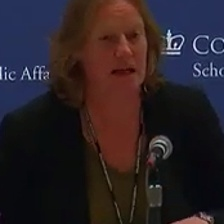

In [ ]:
#@title Check Frame Generati
import cv2

unnormalize = transforms.Normalize((-0.48145466/0.26862954, -0.4578275/0.26130258, -0.40821073/0.27577711), (1/0.26862954, 1/0.26130258, 1/0.27577711))
img = transforms.ToPILImage()(unnormalize(frames[28])).convert("RGB")
img = np.array(img)
cv2.imwrite('test.jpg', img)
print(labels[31])
display(ImagePy('test.jpg'))

In [8]:
#@title Set Seeds
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    #torch.manual_seed(seed) lo stetto già nel modello
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [9]:
#@title Classifier Model
from torch.nn import functional as F
import torch.nn.init as init

class MLP(torch.nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = torch.nn.Linear(512, 64)
        self.bn1 = torch.nn.BatchNorm1d(64)
        self.fc2 = torch.nn.Linear(64, 64)
        self.bn2 = torch.nn.BatchNorm1d(64)
        self.fc3 = torch.nn.Linear(64, 1)

    def forward(self, x):
        x = F.relu(self.bn1(self.fc1(x)))
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.fc3(x)
        return x

def weights_init(m):
    if isinstance(m, torch.nn.Linear):
        init.xavier_uniform_(m.weight.data)
        print("Xavier")

In [10]:
#@title Custom Clip Model
class CustomCLIP(torch.nn.Module):
  def __init__(self):
    super().__init__()
    torch.manual_seed(0)  # Set the seed
    model = clip_model

    self.encoder = model.visual.float()

    self.classifier = MLP() # Classifier
    #self.classifier.apply(weights_init)

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    x = self.encoder(x)
    x = self.classifier(x)
    return x

In [11]:
#@title Training & Test Steps
from tqdm import tqdm
from sklearn.metrics import f1_score, roc_auc_score

def training_step(net, data_loader, optimizer, cost_function, device='cuda'):
    samples = 0.0
    cumulative_loss = 0.0
    cumulative_accuracy = 0.0
    true_labels = []
    predicted_labels = []

    net.train()

    # Iterate over the training set
    for batch_idx, (frames, labels) in enumerate(tqdm(data_loader, desc="Train Progress", leave=False)):
        frames = frames.to(device)
        labels = labels.float().unsqueeze(1).to(device)

        # Forward pass
        outputs = net(frames)

        # Loss computation
        loss = cost_function(outputs, labels)

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        samples += frames.shape[0]
        cumulative_loss += loss.item()

        probabilities = torch.sigmoid(outputs)
        predictions = (probabilities > 0.5).float()

        # Store the true and predicted labels for this batch
        true_labels.extend(labels.detach().cpu().numpy())
        predicted_labels.extend(predictions.detach().cpu().numpy())

        # Compute training accuracy
        cumulative_accuracy += predictions.eq(labels).sum().item()

    if samples==0: print("ZERO SAMPLES GENERATED in train!!!")

    # Convert the lists to numpy arrays
    true_labels = np.array(true_labels)
    predicted_labels = np.array(predicted_labels)

    torch.cuda.empty_cache() #free memory after each epoch

    return cumulative_loss / samples, cumulative_accuracy / samples,

def test_step(net, data_loader, cost_function, device='cuda'):

    cumulative_loss = 0.0
    #cumulative_accuracy = 0.0
    correct_predictions = 0
    total_predictions = 0
    true_labels = []
    predicted_labels = []

    net.eval()

    with torch.no_grad():
        # Iterate over the test set
        for batch_idx, (frames, labels) in enumerate(tqdm(data_loader, desc="Eval Progress", leave=False)):
            frames = frames.to(device)
            labels = labels.float().unsqueeze(1).to(device)

            # Forward pass
            outputs = net(frames)

            # Loss computation
            loss = cost_function(outputs, labels)

            total_predictions += frames.shape[0]
            cumulative_loss += loss.item()
            #_, predicted = outputs.max(1)

            probabilities = torch.sigmoid(outputs)
            predictions = (probabilities > 0.5).float()

            correct_predictions += (predictions == labels).sum().item()

            # Store the true and predicted labels for this batch
            true_labels.extend(labels.detach().cpu().numpy())
            predicted_labels.extend(predictions.detach().cpu().numpy())

            # cumulative_accuracy += predictions.eq(labels).sum().item()

    if total_predictions==0: print("ZERO SAMPLES GENERATED in val!!!")

    test_accuracy = (correct_predictions / total_predictions)

    # Convert the lists to numpy arrays
    true_labels = np.array(true_labels)
    predicted_labels = np.array(predicted_labels)

    # Compute F1 score and AUC
    f1 = f1_score(true_labels, predicted_labels, average='macro')
    auc = roc_auc_score(true_labels, predicted_labels)

    return cumulative_loss / total_predictions, test_accuracy, f1, auc

In [ ]:
#@title TEST 1 TRAINING EPOCH
data_loader = FineTuneDataGenerator(dataset_path, 64, preprocess, excluded_person, "train")

optimizer = torch.optim.Adam(net.parameters(), lr=args['learning_rate'])
cost_function = torch.nn.BCEWithLogitsLoss(pos_weight=positive_class_weight_tensor)

loss, accuracy = training_step(net, data_loader, optimizer, cost_function, device='cuda')

# Print the results
print(f"Average loss: {loss:.4f}, Average accuracy: {accuracy:.2f}%")

In [12]:
args = {
      'batch_size':64,
      'learning_rate':0.0001,
      'weight_decay':0.0001,
      'epochs': 15,
      'excluded_person':excluded_person,
      'class_weight':positive_class_weight_tensor,
      'wandb_flag': False
    }

In [ ]:
!pip -q install wandb
import wandb
!wandb login

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 18.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.4/196.4 kB 16.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 257.5/257.5 kB 21.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.0 MB/s eta 0:00:00
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
import wandb
wandb.init(
    project="ResNet-Finetuning",
    name="no Long - FINAL",
    config={
    "learning_rate": args['learning_rate'],
    "epochs": args['epochs'],
    "batch_size":args['batch_size'],
    'weight_decay':args['weight_decay'],
    }
)

wandb: Currently logged in as: a-appiani2 (andrea-unibg). Use `wandb login --relogin` to force relogin


In [ ]:
#optimizer = torch.optim.SGD(net.parameters(), lr=args['learning_rate'], momentum=0.9, weight_decay=args['weight_decay'])

In [ ]:
# Load:
checkpoint = torch.load("/content/drive/MyDrive/CLIP models/no_long/no_long_9_epochs")
net.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

In [ ]:
# Change weight_decay
for param_group in optimizer.param_groups:
    param_group['lr'] = 0.00001
    param_group['weight_decay'] = 0.0001

In [13]:
#@title MAIN FUNCTION
import math

def main(
      batch_size,
      learning_rate,
      weight_decay,
      epochs,
      excluded_person,
      class_weight,
      wandb_flag
    ):
  set_seed(42)

  train_generator = FineTuneDataGenerator(dataset_path, batch_size, preprocess, excluded_person, mode="train")
  val_generator = FineTuneDataGenerator(dataset_path, batch_size, preprocess, excluded_person, mode="val")

  #scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=3)
  #scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.1)

  for e in range(epochs):

    train_loss, train_accuracy = training_step(net, train_generator, optimizer, cost_function)
    val_loss, val_accuracy, val_f1, val_auc = test_step(net, val_generator, cost_function)

    train_generator.shuffle_replenish_data()

    print('Epoch {:d}:'.format(e+1))
    print('\tTraining loss {:.7f} \tTraining accuracy {:.4f}'.format(train_loss, train_accuracy))
    print('\tValidation loss {:.7f} \tValidation accuracy {:.4f}'.format(val_loss, val_accuracy))
    print('\tValid F1 Macro {:.4f}   \tValidation AUC {:.4f}'.format(val_f1, val_auc))
    for param_group in optimizer.param_groups:
      print(f"----------------LR:{param_group['lr']}----------WD:{param_group['weight_decay']}-----------------")

    #scheduler.step(val_f1)
    #scheduler.step()

    if math.isnan(val_loss):
      print("NaN values!")
      break

    if wandb_flag: wandb.log({"Training Loss": train_loss, "Training Accuracy": train_accuracy, "Validation Loss": val_loss, "Validation Accuracy": val_accuracy, "Val F1 Macro": val_f1, "Val AUC": val_auc})

    #------ Save Checkpoint ----------------
    torch.save({
        'model_state_dict': net.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    }, f"/content/drive/MyDrive/CLIP models/no_bollinger/no_bollinger_{e+1}_epochs")

  train_generator.close_file()
  val_generator.close_file()
  if wandb_flag: wandb.finish()

In [14]:
#@title Initialize Model
net = CustomCLIP().to(device)

trainable_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
print(f'Number of trainable parameters: {trainable_params}')

Number of trainable parameters: 56297249


In [15]:
optimizer = torch.optim.Adam(net.parameters(), lr=args['learning_rate'], weight_decay = args['weight_decay'])
cost_function = torch.nn.BCEWithLogitsLoss(pos_weight=positive_class_weight_tensor)

In [16]:
main(**args)

--- Training Data ---
bell has 37422 indices
sick has 38526 indices
long has 29391 indices
lieberman has 16400 indices
--- Validation Data ---
bollinger has 15080 indices


Epoch 1:
	Training loss 0.0035565 	Training accuracy 0.9322
	Validation loss 0.0113296 	Validation accuracy 0.4515
	Valid F1 Macro 0.4449   	Validation AUC 0.5038
----------------LR:0.0001----------WD:0.0001-----------------


Epoch 2:
	Training loss 0.0013181 	Training accuracy 0.9575
	Validation loss 0.0065457 	Validation accuracy 0.7174
	Valid F1 Macro 0.6382   	Validation AUC 0.6436
----------------LR:0.0001----------WD:0.0001-----------------


Epoch 3:
	Training loss 0.0004011 	Training accuracy 0.9924
	Validation loss 0.0077038 	Validation accuracy 0.7092
	Valid F1 Macro 0.6958   	Validation AUC 0.6980
----------------LR:0.0001----------WD:0.0001-----------------


Epoch 4:
	Training loss 0.0002786 	Training accuracy 0.9944
	Validation loss 0.0074192 	Validation accuracy 0.7514
	Valid F1 Macro 0.6988   	Validation AUC 0.6918
----------------LR:0.0001----------WD:0.0001-----------------


Epoch 5:
	Training loss 0.0002163 	Training accuracy 0.9953
	Validation loss 0.0148895 	Validation accuracy 0.7108
	Valid F1 Macro 0.7108   	Validation AUC 0.7509
----------------LR:0.0001----------WD:0.0001-----------------


Epoch 6:
	Training loss 0.0002040 	Training accuracy 0.9954
	Validation loss 0.0090379 	Validation accuracy 0.7000
	Valid F1 Macro 0.6840   	Validation AUC 0.6846
----------------LR:0.0001----------WD:0.0001-----------------


Epoch 7:
	Training loss 0.0001668 	Training accuracy 0.9962
	Validation loss 0.0115587 	Validation accuracy 0.7288
	Valid F1 Macro 0.6550   	Validation AUC 0.6570
----------------LR:0.0001----------WD:0.0001-----------------


Epoch 8:
	Training loss 0.0001329 	Training accuracy 0.9969
	Validation loss 0.0082752 	Validation accuracy 0.7256
	Valid F1 Macro 0.6873   	Validation AUC 0.6811
----------------LR:0.0001----------WD:0.0001-----------------


Epoch 9:
	Training loss 0.0001152 	Training accuracy 0.9972
	Validation loss 0.0114893 	Validation accuracy 0.7471
	Valid F1 Macro 0.6868   	Validation AUC 0.6821
----------------LR:0.0001----------WD:0.0001-----------------


Epoch 10:
	Training loss 0.0001059 	Training accuracy 0.9974
	Validation loss 0.0502062 	Validation accuracy 0.6156
	Valid F1 Macro 0.3811   	Validation AUC 0.5000
----------------LR:0.0001----------WD:0.0001-----------------


KeyboardInterrupt: 

In [ ]:
import wandb
wandb.finish()

In [ ]:
from google.colab import runtime
runtime.unassign()

In [ ]:
#@title Tentativi fatti  PROVO LR=0.00001 WD=0.001
# riprovo anche a fare le run 4) 5) solo per contrllare che la prima epoca sia uguale

1) 10 epochs with LR=0.0001 WD=0.001                        best test F1:76%
2) 8 more epochs with same LR and WD                        best test F1:76%    ended because of NaN Losses
3) 8 epochs with 4-step-scheduler from LR=0.001 WD:0.001    best test F1:48%    ended because of NaN Losses
4) 6 epochs with LR=0.0001 WD=0.0001                        best test F1:45%    ended because of NaN Losses
5) 10 epochs with LR=0.0001 WD=0.05                         best test F1:73%
6) 6 epochs with LR=0.00001 and WD=0.001                    best test F1:39%    ended because of NaN Losses
7) 10 epochs LR=0.0001 WD=0.001 until 7, then LR=0.00001    best test F1:43%

In [ ]:
#@title 'batch_size':64, 'learning_rate':0.0001, 'weight_decay':0.0001
# Epoch: 1
# 	Training loss 0.0035565, 	Training accuracy 0.932
# 	Validation loss 0.0113296, 	Validation accuracy 0.452
# 	Valid F1 Macro 0.445, 	Validation AUC 0.504

# Epoch: 2
# 	Training loss 0.0013181, 	Training accuracy 0.957
# 	Validation loss 0.0065457, 	Validation accuracy 0.717
# 	Valid F1 Macro 0.638, 	Validation AUC 0.644

# Epoch: 3
# 	Training loss 0.0004011, 	Training accuracy 0.992
# 	Validation loss 0.0077038, 	Validation accuracy 0.709
# 	Valid F1 Macro 0.696, 	Validation AUC 0.698

# Epoch: 4
# 	Training loss 0.0002786, 	Training accuracy 0.994
# 	Validation loss 0.0074192, 	Validation accuracy 0.751
# 	Valid F1 Macro 0.699, 	Validation AUC 0.692

# Epoch: 5
# 	Training loss 0.0002163, 	Training accuracy 0.995
# 	Validation loss 0.0148895, 	Validation accuracy 0.711
# 	Valid F1 Macro 0.711, 	Validation AUC 0.751

# Epoch: 6
# 	Training loss 0.0000993, 	Training accuracy 0.998
# 	Validation loss 0.0093492, 	Validation accuracy 0.710
# 	Valid F1 Macro 0.669, 	Validation AUC 0.664

# Epoch: 7
# 	Training loss 0.0000712, 	Training accuracy 0.999
# 	Validation loss 0.0115376, 	Validation accuracy 0.714
# 	Valid F1 Macro 0.633, 	Validation AUC 0.639

In [ ]:
#@title 'batch_size':32,'learning_rate':0.0001,'weight_decay':0.001
# Epoch: 1
# 	Training loss 0.0063729, 	Training accuracy 0.935
# 	Validation loss 1.2044284, 	Validation accuracy 0.616
# 	Valid F1 Macro 0.381, 	Validation AUC 0.500
# -----------------------------------------------------
# Epoch: 2
# 	Training loss 0.0018923, 	Training accuracy 0.973
# 	Validation loss 0.0172123, 	Validation accuracy 0.653
# 	Valid F1 Macro 0.478, 	Validation AUC 0.548
# -----------------------------------------------------
# Epoch: 3
# 	Training loss 0.0009710, 	Training accuracy 0.989
# 	Validation loss 0.0538170, 	Validation accuracy 0.616
# 	Valid F1 Macro 0.381, 	Validation AUC 0.500
# -----------------------------------------------------
# Epoch: 4
# 	Training loss 0.0006937, 	Training accuracy 0.992
# 	Validation loss 0.0427640, 	Validation accuracy 0.625
# 	Valid F1 Macro 0.407, 	Validation AUC 0.512
# -----------------------------------------------------
# Epoch: 5
# 	Training loss nan, 	Training accuracy 0.866
# 	Validation loss nan, 	Validation accuracy 0.616
# 	Valid F1 Macro 0.381, 	Validation AUC 0.500

In [ ]:
#@title Graph
import matplotlib.pyplot as plt

# Assuming the losses and accuracies are stored in lists
epochs = list(range(1, 11))
training_loss = [0.00925, 0.00734, 0.00964, 0.00719, 0.00671, 0.00565, 0.00497, 0.00470, 0.00453, 0.00459]
validation_loss = [0.00785, 0.00839, 0.04308, 0.00684, 0.00637, 0.00578, 0.00538, 0.00525, 0.00515, 0.00460]

plt.figure(figsize=(10,5))

# Plotting training loss
plt.subplot(1, 2, 1)
plt.plot(epochs, training_loss, label='Training Loss')
plt.plot(epochs, validation_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

training_accuracy = [0.62, 0.66, 0.66, 0.63, 0.65, 0.73, 0.80, 0.81, 0.82, 0.82]
validation_accuracy = [0.63, 0.61, 0.63, 0.64, 0.66, 0.76, 0.81, 0.80, 0.83, 0.82]

# Plotting training accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, training_accuracy, label='Training Accuracy')
plt.plot(epochs, validation_accuracy, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()
